# Astrometric analysis with ePSF

This notebook evaluates the dependency of the position determination accuracy on the number of objects.

The analysis is performed on the results for 12.0 mag data.

## Importing some modules

In [1]:
import copy, warnings
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.modeling import models, fitting
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import simple_norm
from photutils.background import MMMBackground
from photutils.detection import find_peaks
from photutils.psf import EPSFBuilder, extract_stars

## Defining a function

In [2]:
def func(filename, sp_filename, mag, ndiv):
    '''
    filename: Name of the input FITS file.
    sp_filename: Name of the input star-plate file.
    '''
    
    mask_size = 25   # Edge mask size.
    ext_size  = 9    # Size of extraction window.
    n_oversample = 4 # Number of oversampling for ePSF.
    n_maxiter    = 3 # Max. number of iteration for making ePSF.
    threshold = 3000.*10.**((mag-12.0)/(-2.5))
    print("Analyzing {}...".format(filename))
    
    # Loading image.
    hdu = pf.open(filename)[0]
    data = hdu.data.astype(np.float32)
    norm = simple_norm(data, 'sqrt', percent=99.)
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.show()
    
    # Finding peaks.
    peaks_tbl = find_peaks(data, threshold=threshold)
    peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
#    print(peaks_tbl)
    
    # Removing detections near edge.
    hsize = (mask_size - 1) / 2
    x = peaks_tbl['x_peak'] 
    y = peaks_tbl['y_peak'] 
    mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
#    print(stars_tbl)
    
    # Subtracting background.
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
    image = copy.deepcopy(data)
    data -= mean_val
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')

    # Extracting stellar images.
    nddata = NDData(data=data)
#    print(nddata.data.shape)
    stars0 = extract_stars(nddata, stars_tbl, size=ext_size)
    
    dxarr=np.array([]); dyarr=np.array([]); drarr=np.array([]);
    for idiv in range(ndiv):
        stars = stars0[idiv::ndiv]
#        nrows = 10
#        ncols = 10
#        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
#        ax = ax.ravel()
#        for i in range(nrows*ncols):
#            norm = simple_norm(stars[i], 'log', percent=99.)
#            ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
#        plt.show()

        # Making ePSF.
        epsf_builder = EPSFBuilder(oversampling=n_oversample,
                                   maxiters=n_maxiter, progress_bar=True)
        epsf, fitted_stars = epsf_builder(stars)
#        norm = simple_norm(epsf.data, 'log', percent=99.)
#        plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
#        plt.xlabel('X (oversampled pix)')
#        plt.ylabel('Y (oversampled pix)')
#        plt.colorbar()
#        plt.show()

        # Loading stellar-plate data.
        original = np.loadtxt(sp_filename,skiprows=1,delimiter=",")
    
        # Cross-checking the data.
        xc_array = []
        for o in original:
            diff = fitted_stars.center_flat-np.array([o[2],o[3]])
            p = np.where(diff[:,0]**2.+diff[:,1]**2.<10.**2.)
            if np.size(p) == 1:
                xc_array.append([o[2], o[3],
                                 fitted_stars.center_flat[p[0][0]][0],
                                 fitted_stars.center_flat[p[0][0]][1]])
        xc_array = np.array(xc_array)
#        print(xc_array)
    
        # Making dx/dy data.
        dx = xc_array[:,2] - xc_array[:,0]
        dy = xc_array[:,3] - xc_array[:,1]
###        dx = dx - np.mean(dx)
###        dy = dy - np.mean(dy)
#        plt.scatter(dx, dy)
#        plt.xlabel('$\Delta$x (px; w/o global offset)')
#        plt.ylabel('$\Delta$y (px; w/o global offset)')
#        plt.show()
    
#        plt.axes().set_aspect('equal')
#        plt.quiver(xc_array[:,2], xc_array[:,3], dx, dy,
#                   angles='xy', scale_units='xy', scale=0.0003)
#        plt.xlabel('X (px)')
#        plt.ylabel('Y (px)')
#        plt.xlim([0, 1920])
#        plt.ylim([0, 1920])
#        plt.show()
    
        # Calculating stddev.
#        print("STDDEV DX: {} px".format(np.std(dx)))
#        print("STDDEV DY: {} px".format(np.std(dy)))
        dxarr = np.concatenate([dxarr, dx])
        dyarr = np.concatenate([dyarr, dy])
###        drarr.append(np.std(np.sqrt(dx*dx+dy*dy)))

    dxarr = dxarr - np.mean(dxarr)
    dyarr = dyarr - np.mean(dyarr)
    drarr = np.sqrt(dxarr**2.+dyarr**2.)

    return np.std(dxarr,ddof=1), np.std(dyarr, ddof=1), np.std(drarr, ddof=1)

In [3]:
res=[];
for ndiv in [1,2,4,8,16,32,64,128]:
    print(ndiv)
    sra=[];
    #for mag in np.arange(12.0,15.0,0.5):
    for mag in [12.0]:
        tmp = []
        for i in range(0,11):
            print(i)
            sx, sy, sr = func("image.{:4.1f}.{:02d}.fits".format(mag,i),
                              "../01_params/spcsv_20_1920_10_20_12.0.csv", mag, ndiv)
            tmp.append(sr)
        sra.append(tmp)
    sra = np.array(sra)
    acc = np.mean(sra.flatten())
    unc = np.std(sra.flatten(),ddof=1)/np.sqrt(np.size(sra.flatten()))
    res.append([ndiv, acc, unc])
res = np.array(res)

1
0
Analyzing image.12.0.00.fits...
1
Analyzing image.12.0.01.fits...
2
Analyzing image.12.0.02.fits...
3
Analyzing image.12.0.03.fits...
4
Analyzing image.12.0.04.fits...
5
Analyzing image.12.0.05.fits...
6
Analyzing image.12.0.06.fits...
7
Analyzing image.12.0.07.fits...
8
Analyzing image.12.0.08.fits...
9
Analyzing image.12.0.09.fits...
10
Analyzing image.12.0.10.fits...
2
0
Analyzing image.12.0.00.fits...
1
Analyzing image.12.0.01.fits...
2
Analyzing image.12.0.02.fits...
3
Analyzing image.12.0.03.fits...
4
Analyzing image.12.0.04.fits...
5
Analyzing image.12.0.05.fits...
6
Analyzing image.12.0.06.fits...
7
Analyzing image.12.0.07.fits...
8
Analyzing image.12.0.08.fits...
9
Analyzing image.12.0.09.fits...
10
Analyzing image.12.0.10.fits...
4
0
Analyzing image.12.0.00.fits...
1
Analyzing image.12.0.01.fits...
2
Analyzing image.12.0.02.fits...
3
Analyzing image.12.0.03.fits...
4
Analyzing image.12.0.04.fits...
5
Analyzing image.12.0.05.fits...
6
Analyzing image.12.0.06.fits...
7
Anal

In [4]:
res

array([[1.00000000e+00, 4.34677151e-03, 5.98585921e-05],
       [2.00000000e+00, 4.71437759e-03, 6.21885412e-05],
       [4.00000000e+00, 6.05163969e-03, 9.00616430e-05],
       [8.00000000e+00, 7.95309417e-03, 1.02120710e-04],
       [1.60000000e+01, 9.83399409e-03, 9.13801259e-05],
       [3.20000000e+01, 1.13290080e-02, 1.30482099e-04],
       [6.40000000e+01, 1.47727689e-02, 1.08545175e-04],
       [1.28000000e+02, 2.10473901e-02, 5.07770295e-04]])

In [5]:
res = np.array(res)

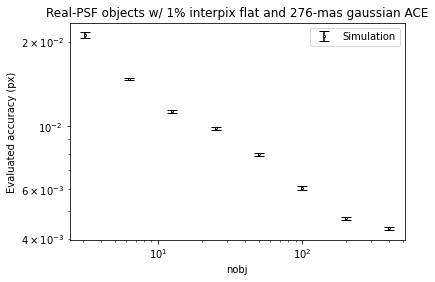

In [6]:
plt.errorbar(400./res[:,0], res[:,1], yerr=res[:,2], capsize=5, fmt='o', markersize=2, 
             ecolor='black', markeredgecolor = "black", color='w', label='Simulation')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('nobj')
plt.ylabel('Evaluated accuracy (px)')
plt.title('Real-PSF objects w/ 1% interpix flat and 276-mas gaussian ACE')
plt.legend()
plt.show()